In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

Populating the interactive namespace from numpy and matplotlib


In [295]:
sample_info = pd.read_csv('BC_sample_info.csv', index_col=0)

df = pd.read_table('data/Layer2_BC_count_matrix-1.tsv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

In [296]:
import NaiveDE

In [297]:
dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

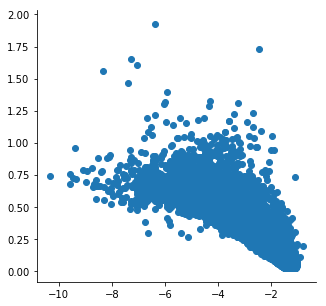

In [298]:
plt.scatter(res.mean(), res.var());

In [299]:
idx = res.index

In [300]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [301]:
pca = PCA()
Y = pca.fit_transform(scale(res.loc[idx], 1))

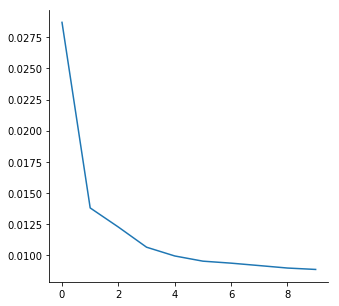

In [302]:
plt.plot(pca.explained_variance_ratio_[:10]);

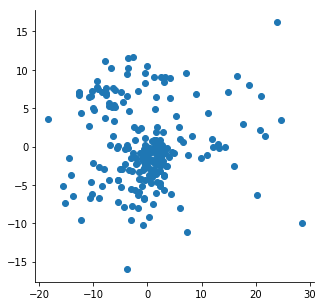

In [303]:
figsize(5, 5)
plt.scatter(Y[:, 0], Y[:, 1]);

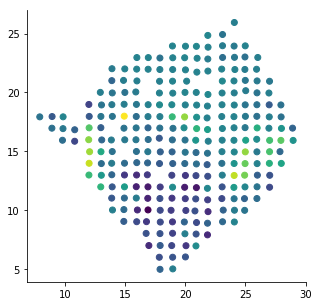

In [304]:
plt.scatter(sample_info['x'], sample_info['y'], c=Y[:,0]);

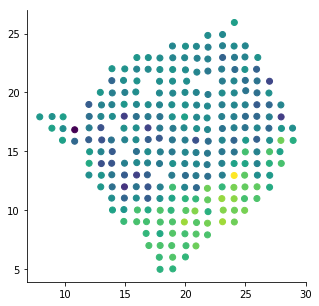

In [305]:
plt.scatter(sample_info['x'], sample_info['y'], c=Y[:,1]);

In [353]:
from sklearn.mixture import BayesianGaussianMixture

In [354]:
gmm = BayesianGaussianMixture(n_components=20, max_iter=10000)

In [355]:
gmm.fit(Y[:, :2])

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=10000, mean_precision_prior=None, mean_prior=None,
            n_components=20, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [356]:
phi_hat = gmm.predict(Y[:, :2])

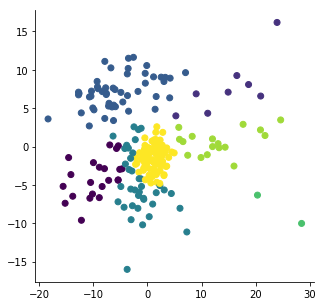

In [357]:
figsize(5, 5)
plt.scatter(Y[:, 0], Y[:, 1], c=phi_hat);

In [358]:
gmm

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=10000, mean_precision_prior=None, mean_prior=None,
            n_components=20, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

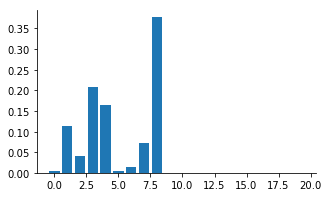

In [359]:
figsize(5, 3)
plt.bar(range(len(gmm.weights_)), gmm.weights_);

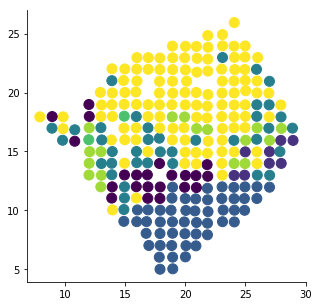

In [360]:
figsize(5, 5)
plt.scatter(sample_info['x'], sample_info['y'], c=phi_hat, s=100);

In [361]:
sample_info['cluster'] = phi_hat

In [362]:
de_results = NaiveDE.lr_tests(sample_info, res.T, '~ C(cluster)')

In [363]:
sde_results = pd.read_csv('BC_final_results.csv', index_col=0)

In [364]:
de_results = de_results.sort_index()
sde_results = sde_results.sort_values('g')

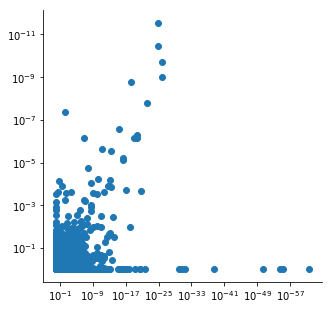

In [365]:
plt.loglog()
plt.scatter(de_results['qval'], sde_results['qval']);
ax = plt.gca()
ax.invert_yaxis()
ax.invert_xaxis();

In [366]:
sig_genes = sde_results.query('qval < 0.05')['g'].sort_values().values
more_sig = de_results.loc[sig_genes].query('qval > 0.05').sort_values('qval')
more_sig

,Intercept,C(cluster)[T.2],C(cluster)[T.3],C(cluster)[T.4],C(cluster)[T.6],C(cluster)[T.7],C(cluster)[T.8],pval,qval
PNMT,-3.038422,0.727850,-0.077516,0.158193,0.157351,0.649743,0.187323,0.000225,0.056326
ITIH2,-2.929896,-0.152544,-0.249195,0.130658,0.385805,0.369209,0.054174,0.000361,0.090224
COX6B1,-5.875194,1.057009,-0.037428,0.411625,0.943045,0.596297,0.559250,0.000535,0.133756
LRRC15,-2.343799,-0.736957,0.073309,-0.282342,-0.837682,-0.341599,-0.227876,0.000618,0.154486
CLEC3A,-4.297462,0.877008,0.561542,0.002245,-0.089846,0.703219,0.428327,0.000681,0.170361
RPL8,-4.871734,0.073643,-0.549851,0.092653,0.602086,-0.043706,0.069382,0.000702,0.175618
STC2,-3.447578,-0.000755,0.112127,0.332786,1.474176,0.640725,0.290680,0.001183,0.295650
WDR5B,-1.335172,-0.009980,0.000767,0.042276,-0.015965,0.080358,0.029321,0.581518,1.000000
TYW5,-1.460547,-0.097078,0.033432,-0.058805,0.630679,-0.001603,-0.020720,0.004002,1.000000
SSPO,-1.282435,-0.004699,0.000361,0.065293,-0.007518,-0.003451,0.020849,0.701062,1.000000


In [367]:
sde_results.query('g in @more_sig.index')[['g', 'l', 'qval']].sort_values('qval')

,g,l,qval
8785,CLEC3A,1.843940,0.000072
9519,STC2,1.843940,0.000250
11227,PI15,3.125663,0.000290
8931,IGFBP5,1.843940,0.000707
2837,SSPO,0.641736,0.001224
3461,ZNF880,0.641736,0.001590
2779,ETV7,0.641736,0.002968
3426,WDR5B,0.641736,0.005971
1648,ITGAX,0.641736,0.008229
3382,TYW5,0.641736,0.014491


In [368]:
more_sig.shape

(24, 9)

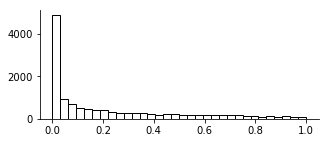

In [369]:
figsize(5, 2)
de_results.pval.hist(bins=32, fc='w', ec='k', grid=False);

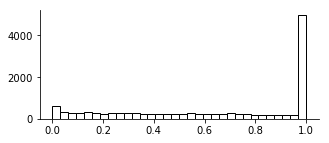

In [370]:
figsize(5, 2)
sde_results.pval.hist(bins=32, fc='w', ec='k', grid=False);